In [2]:
pwd

'/home/burgaya/Desktop/BactCoviData/workflow/jupyter-notebooks'

In [3]:
import sweetviz as sv

In [4]:
import pandas as pd
import numpy as np
from pyfish import fish_plot, process_data, setup_figure

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [5]:
### extract samples ids from hospital metadata
m = pd.read_csv("../../data/hospital.tsv", sep="\t")

/home/burgaya/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
s = m[["sampleid", "samplingdate"]]

In [7]:
s["fastaid"] = s["sampleid"] + ".fna"

/tmp/ipykernel_10304/678489483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["fastaid"] = s["sampleid"] + ".fna"


In [8]:
s.to_csv("../../data/samples.tsv", sep="\t")

In [9]:
ec_sra_path = "../../data/ec_filtered_d_sra.tsv"
kp_sra_path = "../../data/kp_filtered_d_sra.tsv"
pa_sra_path = "../../data/pa_filtered_d_sra.tsv"
mhh_path = "../../data/StudyDataGalardini_pseudonymized_v1_SENT_2022-11-17.xlsx"
cph_path = "../../data/metadata_marco_04082023.xlsx"
cph_key_path = "../../data/material_key.xlsx"
bs_path = "../../data/KBS_strains+TC_Stand30052023new.xlsx"

In [10]:
ec_sra = pd.read_csv(ec_sra_path, sep="\t")
kp_sra = pd.read_csv(kp_sra_path, sep="\t")
pa_sra = pd.read_csv(pa_sra_path, sep="\t")

In [11]:
mhh = pd.read_excel(mhh_path)
cph = pd.read_excel(cph_path)
cph_k = pd.read_excel(cph_key_path)
bs = pd.ExcelFile(bs_path)
bs_ec = pd.read_excel(bs, 1)
bs_kp = pd.read_excel(bs, 2)

In [12]:
# get sra df
# drop columns with missing values or useless
ec_sra.drop(columns=["Month", "BioSampleModel", "geo_loc_name", "Strain", "Library Name", "version", 
                      "LibrarySelection", "Organism", "Bytes", "AvgSpotLen", "Bases", "DATASTORE filetype",
                      "DATASTORE provider", "DATASTORE region", "Experiment", "LibrarySelection", "ReleaseDate",
                      "Sample Name", "create_date", "Date"], inplace=True)
kp_sra.drop(columns=["Month", "Library Name", "version", "LibrarySelection", "Organism", "Bytes", "AvgSpotLen", 
                     "Bases", "DATASTORE filetype", "DATASTORE provider", "DATASTORE region", "Experiment", 
                     "LibrarySelection", "ReleaseDate", "Sample Name", "create_date", "Date"], inplace=True)
pa_sra.drop(columns=["Month", "BioSampleModel", "geo_loc_name", "Library Name", "version", 
                      "LibrarySelection", "Organism", "Bytes", "AvgSpotLen", "Bases", "DATASTORE filetype",
                      "DATASTORE provider", "DATASTORE region", "Experiment", "LibrarySelection", "ReleaseDate",
                      "Sample Name", "create_date", "BioSampleModel", "Date"], inplace=True)

# drop rows with assay type == ['WGA', 'CLONE', 'FINISHING', 'WCS']
assay_type = ['WGA', 'CLONE', 'FINISHING', 'WCS']
ec_sra = ec_sra[~ec_sra['Assay Type'].isin(assay_type)]
kp_sra = kp_sra[~kp_sra['Assay Type'].isin(assay_type)]
pa_sra = pa_sra[~pa_sra['Assay Type'].isin(assay_type)]

# drop rows with platform == OXFORD_NANOPORE
platform = ['OXFORD_NANOPORE']
ec_sra = ec_sra[~ec_sra['Platform'].isin(platform)]
kp_sra = kp_sra[~kp_sra['Platform'].isin(platform)]
pa_sra = pa_sra[~pa_sra['Platform'].isin(platform)]

# drop rows with LibraryLayout == SINGLE
layout=['SINGLE']
ec_sra = ec_sra[~ec_sra['LibraryLayout'].isin(layout)]
kp_sra = kp_sra[~kp_sra['LibraryLayout'].isin(layout)]
pa_sra = pa_sra[~pa_sra['LibraryLayout'].isin(layout)]

# drop rows with LibrarySource == ['OTHER', 'METAGENOMIC', 'GENOMIC SINGLE CELL']
l_source = ['OTHER', 'METAGENOMIC', 'GENOMIC SINGLE CELL']
ec_sra = ec_sra[~ec_sra['LibrarySource'].isin(l_source)]
kp_sra = kp_sra[~kp_sra['LibrarySource'].isin(l_source)]
pa_sra = pa_sra[~pa_sra['LibrarySource'].isin(l_source)]

# look at Isolation_source column - might be not human
human_source = ["stool", "feces", "bile", "urine", "Rectal Swab", "liver", "Femur", "bone marrow", "spleen", "human", "GN Broth Stool", "abdominal fluid",
                "Peritoneum", "Pericardia", "sputum", "fecal sample", "Rectal swab", "bloodstream", "Rectal abscess", "Rectal",
                "blood", "Bile Duct Fluid", "Wound culture", "Rectal Specimen", "recto anal mucosal swab", "Patient Blood", "Ileostomy Bag 1 Swab",
                "Patient Urine", "Patient Sputum", "Patient hydatid fluid", "Patient Drainage", "Pus", "clinical sample",
                "respiratory", "wound", "blood culture", "E. coli K-12 from a stool sample of a diphtheria patient in Palo Alto\, CA in 1922",
                "clinical", "oral", "puncture fluid", "ascitic fluid", "intestine", "throat", "wound swab", "endocervical",
                "cerebrospinal fluid", "Abscess", "Peritoneal fluid", "CSF", "Ascitic fluid", "Abscess fluid", "rectal faeces",
                "rectal swab", "CF Sputum", "rectal swap", "Necrotic tissue", "Blood culture", "Human\, Stool", "Human\, Blood culture",
                "pus", "fluid", "Fluid", "lung", "bladder epithelial biopsy from 60-year-old female patient with recurrent urinary tract infection",
                "bladder epithelial biopsy from 30-year-old female patient with recurrent urinary tract infection", "Swab (Site:)", ""
                "bladder epithelial biopsy from 50-year-old female patient with recurrent urinary tract infection", "tissue", "tracheal aspirate",
                "swab", "cecal content", "Skin swab", "Human gut", "pancreas", "ear", "peritoneal fluid", "vagina", "skin", "Broncho-alveolar lavage",
                "stool sample", "lung swab", "uterine swab", "sinus swab", "urine swab", "soft tissue", "kidney", "joint swab",
                "oral swab", "eye", "endometrial swab", "pharyngeal tissue", "abdomen", "respiratory tract", "Anal gland",
                "Right Ear Swab", "Foot Swab", "Prostrate", "Wound/Abscess", "rectum", "Faecal samples", "Abdominal wound discharge",
                "Secretion", "Catheter", "Human Sample", "Faeces or rectal swab", "Umbilical swab", "Wound Swab", "Pooled: Liver\, Peritoneum\, Abscess",
                "nasal swab", "Uterine swab", "fecal microbiome", "heart swab", "liver swab", "vaginal swab", "uterus", "joint fluid",
                "pericardium", "umbilicus", "lungs", "outbreaks of food poisoning", "diarrhea from outbreaks of food poisoning",
                "Uterus", "semen", "nasal cavity", "rectal feces", "Blood_Blood", "swab (superficial and non-surgical)", "swab (cavity)",
                "unspecified diagnostic sample", "swab (wound)", "punctate", "biopsy", "surgical sample", "PUS", "Pus from Wound",
                "Tissue", "Blood specimen", "Small intestine", "Urine_", "Exudate", "Catheter Tip", "Anal glands", "Skin wound", "urin", "urachus swab",
                "Abdominal", "Perirectal", "FLUID", "TISSUE", "ICU staff rectal swab", "blood draw same patient as MB9267", "Peritoneal Fluid",
                "Wound Discharge", "Cecal Contents", "Diseased Organ", "Perianal Swab", "Perineum Swab", "Rectal Isolate", "Graft Tissue",
                "Abdomen Fluid", "Abdomen Tissue", "Kidney Swab", "Perineal Swab", "Endotracheal Aspirate", "Perianal", "Catheter Urine",
                "rectal", "Blood Specimen", "Cecum", "Faecal swab", "hand swab (farm workers)", "feces (farm workers)",
                "cecal", "nose swab (farm workers)", "nose swab (abattoir operator households)", "anal swab", "hand swab (abattoir operator households)",
                "feces (abattoir operator households)", "abdominal drainage", "midstream urine", "Feaces", "Perianal Abscess Swab", "Right Leg Fluid",
                "Mid stream Urine", "Anal Swab", "Aortic Tissue", "Screening Swab", "Ankle Wound Tissue", "Periph.Ins.Central Catheter Tip",
                "Cecal content", "secretion", "Foreskin", "ICU patient rectal swab", "ICU patient oral swab", "human clinical specimen", "JSE66:midstream urine", "JSE19:midstream urine",
               "JSE46:midstream urine", "JSE44:midstream urine", "JSE38:midstream urine", "JSE16:midstream urine", "JSE15:midstream urine", "Central venous catheter tip culture",
               ""]

hospital_source = ["hospital sewage", "hospital", "Hospital influent", "Hospital efluent", "Baby Bath Drain Special Care Nursery"]

environmental_source = ["The intestines of the diarrhea donkey foal", "guinea fowl meat", "raw pet food", "feces (Ovis aries)", "rat", "capercailie grouse", "goose",
                        "surgical site (Canis lupus familiaris)", "Skin (Canis lupus familiaris)", "Cattle feces", "prepuce (Canis lupus familiaris)",
                        "Ear swab (Canis lupus familiaris)", "Mass (Canis lupus familiaris)", "Anal gland (Canis lupus familiaris)", "Urine swab (Canis lupus familiaris)",
                        "Thorax swab (Canis lupus familiaris)", "hay", "water for animals", "environmental swab lairage", "carcass swab sheep", "feces cattle", "cecum content sheep",
                        "turkey", "Chicken Breasts", "Chicken Legs", "Pork chops", "Chicken wings", "cattle barrier", "Poultry barrier", "cattle", "feces resting area",
                        "Animal feed (hay)", "Pig gut digesta", "liver (Canis lupus familiaris)", "sheep cecal content", "Nose (Canis lupus familiaris)",
                        "fecal bovine", "sheep lairage swab", "sheep carcass swab", "sheep feces", "sheep feed", "mass (Canis lupus familiaris)", "abdoman (Canis lupus familiaris)",
                        "tube swab (Canis lupus familiaris)", "Feces (Felis catus domesticus)", "Skin wound (Canis lupus familiaris)", "Lung (Canis lupus familiaris)",
                        "enriched white flour", "leg bone from commercial broiler", "turkey spleen", "chicken joint", "chicken spleen", "chicken heart", "cattle farm waste water",
                        "swab (Canis lupus familiaris)", "skin(Canis lupus familiaris)", "canine feces", "raw dog food", "Other (Canis lupus familiaris)", "spleen (Canis lupus familiaris)",
                        "poultry air", "bovine air", "produce near cattle", "Poultry Soil", "bovine soil", "poultry soil", "bovine barrier", "cheese", "produce near bovine",
                        "feces bovine", "control air", "Bovine Barrier", "Produce near Cattle", "Bovine Soil", "Brioler (Poultry)", "incision swab (Canis lupus familiaris)",
                        "scat", "baby red chard", "Northboro reserve storm water drain", "Urine (Canis lupus familiaris)", "manure bird scat", "cow manure", "pork chop", 
                        "soil bird dropping manure", "Bladder (Canis lupis familiaris)", "Vaginal swab (Canis lupis familiaris)", "Urine (Canis lupis familiaris)", "Nasal discharge (Felis catus domesticus)",
                        "Surgical site (Canis lupis familiaris)", "swab sponges", "resting area feces", "feed", "Feces (Canis lupus familiaris)", "Center of yard (Environmental)", "Edge of yard (Environmental)",
                        "Feces (Felis catus)", "ear swab (Canis lupus)", "swab (Canis lupus)", "broiler", "animal", "soil scat", "water reservoir", "Vaginal swab (Canis lupus familiaris)",
                        "Estuarine mud", "feces (Canis lupus)", "urine (Felis catus)", "swab (Canus lupus)", "chicken", "Mouse", "food ice cream", "lettuce iceberg", "ferret",
                        "feces (Canius lupus)", "colon (Sus domesticus)", "military dog fecal sample", "private dog fecal sample", "feces poultry", "uterine swab (Canis familiaris)",
                      "fecal beef heifer", "food", "beef trim", "ground beed patty", "Washington", "soil", "untreated waste water", "poultry litter", "work desk",
                      "potable source water", "pizza dough dry mixture", "Raw Beef", "Apple cider", "flour", "skin (Canis lupus familiaris)", "cilantro", "chicken yolk sac",
                      "venison", "lettuce", "spinach", "environmental", "romaine lettuce", "leafy green", "bovine", "Pig Lung", "Chicken Lung", "Chicken Liver",
                      "waste water primary treatment", "Wastewater\, primary treatment", "reclaimed distribution system", "Chicken faeces", "Chicken Faeces",
                      "environmental reclaimed storage", "bird feces", "feces bird", "Manure/Bedding", "pizza flour mixture", "chair", "Retail chicken skin",
                      "kale", "drag swab through chicken house (Gallus gallus domesticus)", "milk", "feces (Bos taurus)", "ground meat", "parsley", "canine transtracheal wash",
                      "all-purpose wheat flour", "water", "cloaca", "chicken house back", "chicken house middle", "urine (Feline)", "canine prepuce", "canine kidney",
                        "equine incision site", "bladder mucosa (Canis lupus familiaris)", "fresh cilantro", "uterus (Canis lupus)", "canine uterus", "cow paddock straw bedding",
                      "feces calf", "fecal calf", "feces calf (Bos taurus)", "fecal cow (Bos taurus)", "fecal cow", "beef carcass", "raw beef trim",
                      "pig", "water", "feces (Capra hircus)", "forage", "all-purpose flour", "unbleached white flour", "uterus (Canis lupus familiaris)", "canine abscess",
                      "Ground beef", "fresh persian cucumber", "basil", "canine urine swab", "canine urine", "lung (Canis lupus familaris)", "infected wound swab (Equus caballus)",
                      "urine (Canis lupus)", "bladder (Canis lupus familiaris)", "urine (Canis lupus familaris)", "turkey yolk sac", "yolk sac", "Cattle faeces", 
                      "Swine wastewater", "Feces\, Bald Eagle (Haliaeetus leucocephalus)", "Feces\, Gull (Larus spp.)", "gastrointestinal tract (Bos taurus)",
                      "creamy soy nut butter", "wheat flour", "beef", "cucumber", "chicken house back inside", "sheep goat next barn", "red cabbage", "raw beef pet food",
                      "cow pasture fecal", "chicken water", "tomato", "sheep goat middle pasture", "sheep pen with peacock", "chicken house front outside", "cattle manure (Bos taurus)",
                      "environmental swab sponge produce source", "sheep goat", "kohlrabi german turnip", "draining tract (Canis lupus familiaris)", "goat", "ear swab (Canis familiaris)",
                      "fresh coriander", "insect", "cow paddock straw bedding bovine steer", "pig feces", "feces goat", "veggie snack", "pig soil", "swab surgical incision (Canis lupus familiaris)",
                      "cow soil", "ear (Canis lupus)", "ear (Canis lupus familiaris)", "feline urine Felis catus)", "stream sediment", "anal sac (Canis lupus familiaris)",
                      "chicken house front", "Sewage water", "pork", "water sewage", "dairy cow feces (Bos taurus)", "environment", "marmoset", "deer whitetail", "intestine (Sus scrofa domesticus)",
                        "environmental sample", "urine (Canis familiaris)", "swab (Canis familiaris)", "canine", "rectum (Canis lupus familiaris)", "canine ear", ""
                        "abscess (Canis lupus familiaris)", "cow paddock straw bedding bovine", "apple cider", "cow", "poultry", "dog", "urine (Canis lupus familiaris)",
                        "cat", "guinea pig", "mink", "Hedgehog", "chicken house front inside", "raw ground beef", "cattle fecal samples", "skin (Canis lupus)", 
                        "Chicken slaughterhouse internal water", "sick pig lung", "Pig anus swab", "Chicken manure", "Chicken slaughterhouse splitting water",
                        "Chicken dung channel", "Chicken anus swab", "Chicken liver", "Pig slaughterhouse plucking water", "Chicken slaughterhouse plucked skin", "Chicken Feces",
                        "Chicken feces", "Chicken slaughterhouse", "Pig Liver", "Intestine (Canis lupus familiaris)", "feces (Canis)", "Ground pork", "Chicken Leg (Gallus gallus)",
                      "water influent", "bovine calf feces (Bos taurus)", "dog lung", "Calf recto-anal mucosal swab", "Calf shed floor", "Calf hide on farm", "Ground Beef (Bos Taurus)",
                      "Calf hide on plant", "Veal carcass pre-intervention", "Water and feed trough", "Calf birthing paddock", "Calf feed trough", "Colostrum feed bucket",
                      "Colostrum cow recto-anal mucosal swab", "Bird feces in calf shed", "Milk filter", "canine uterine swab", "cow paddock straw bedding bovine dairy",
                      "porcine feces", "canine ear swab", "not collected", "raw turkey dog food", "Bovine hide", "ground beef", "turkey intestine", "bison ground meat",
                      "ground frozen venison based cat food", "gall bladder (Canis lupus familiaris)", "mink intestine (Neovison vison)", "feces (Canis lupus familaris)",
                      "skin swab (Canis lupus familiaris)", "tissue (Canis lupus familiaris)", "feces (Felis catus)", "intestine (Canis lupus familiaris)", "Ground Pork (Sus domesticus)",
                      "river water", "sediment", "household environment", "surface", "doorknob", "control air", "reservoir water", "biliary stone (Canis lupus familiaris)",
                      "Environment", "water reservoir", "Raw wastewater from aircraft arriving at an international German airport", "pork chop (Sus scrofa)", "foot swab (Canis lupus familiaris)",
                        "Raw wastewater from three airplanes arriving from Singapore\, Mombasa and Canada", "ear swab (Canis lupus familiaris)", "suppuration (Canis lupus familiaris)",
                        "Rat feces from intestine (Rattus norvegicus)", "urinary stone (Canis lupus familiaris)", "ready to eat mixed salad leaves (obtained from discount store)",
                        "Trachea (Canis lupus familiaris)", "Ear (Canis lupus familiaris)", "Urine (Felis catus domesticus)", "Bladder (Canis lupus familiaris)",
                      "Raw wastewater from three airplanes arriving from Singapore\, Mombasa and Canada", "cattle farm waste water", "urine swab (Canis lupus familiaris)",
                       "urine (Canis lupus familiaris) cystocentesis", "feces (Sus scrofa domesticus)", "cattle manure", "Mouth (Canis lupus familiaris)", "lip (Canis lupus familiaris)",
                      "wastewater", "environmental swab lairage", "Environmental sample: soil sample", "cloacal swab", "gastrointestinal tract (Sus domesticus)", "Ground Pork ( Sus domesticus)",
                      "environmental swab", "Cistern water", "pond water", "water cistern", "fresh water stream surface", "rat feces from intestine (Rattus norvegicus)",
                        "Pork Chop (Sus domesticus)", "Ground Turkey (Meleagris gallopavo)", "poultry liver", "poultry water", "Ground Beef (Bos taurus)", "Bround Beef ( Bos Taurus)",
                      "Manawatu river", "cattle farm", "dairy farm field soil", "Storm water drain", "Floor swab", "sold in market", "Retail chicken", "Chicken Leg ( Gallus gallus)",
                      "Domestic Wastewaters", "Barn Environment", "Water from irrigation pond", "water pond", "water (slaughter house)", "Ground Turkey ( Meleagris gallopavo)", "Ground Beef ( Bos Taurus)",
                        "aspirate swab from tail base (Canis familiaris)", "oviduct (Galliformes)", "wound swab (Galliformes)", "Chicken Breast ( Gallus gallus)", "Pork Chop ( Sus domesticus)",
                        "Chicken Wings (Gallus gallus)", "poultry fecal", "bison burger", "ground turkey", "chicken wing", "rhesus macaque", "romaine lettuce heart", "chicken thigh",
                        "yolk sac (Meleagris gallopavo)", "yolk sac (Gallus gallus)", "feces sheep", "lairage swab", "Feces (Sheep)", "E-Tube (Canis lupus familiaris)", "canis lupus familiaris",
                        "intestine (Bos taurus)", "urine (Canis lupus) cystocentesis", "tail base swab (Canis lupus)", "avian", "pens", "chicken egg", "rabbit", "chickens", "yoghurt",
                        "tank", "guinea fowl", "turkeys", "duck meat", "primate", "lettuce from ready salad pack", "manure", "trach wash", "feed grass", "Carcass swab (Goat)", "carcass swab (Sheep)",
                        "ground turkey (Meleagris gallopavo)", "ground pork (Sus scrofa)", "ground beef (Bos taurus)", "chicken breast (Gallus gallus)", "chicken wing (Gallus gallus)",
                        "Feces (Bovine)", "uterine swab (Canis lupus familiaris)", "foot (Canis lupus familiaris)", "testicle swab (Canis lupus familiaris)", "transtracheal wash (Canis lupus familiaris)",
                        "equine uterus (Equus caballus)", "heart (Canis lupus familaris)", "vagina (Canis lupus familiaris)", "intestine (Capra aegagrus hircus)", "Canis lupus familiaris",
                        "chicken breast", "feces (Equis)", "ground pork", "Mouse feces (G2 mouse)", "urine (Canius lupus)", "anal gland (Canis lupus familiaris)", "cecal content sheep",
                        "tracheal wash (Canis lupus familiaris)", "Flour", "Canis lupus familaris", "broiler chicken meat", "Momutu stream", "Meola Reef Park storm water drain",
                        "cojita cheese", "Whole Chicken", "Ground Beef", "Chicken Wings", "['Waikato\, New Zealand'\, 'Composite bird faeces']", "['Waikato\, New Zealand'\, 'Farm dairy effluents']",
                        "['Waikato\, New Zealand'\, 'composite calf faeces']", "['Waikato\, New Zealand'\, 'composite calf bedding material (woodchip)']", "['Waikato\, New Zealand'\, 'Composite soil from not recently grazed paddock']",
                        "['Waikato\, New Zealand'\, 'Surface of dairy cows housing systems']", "['Waikato\, New Zealand'\, 'Drinking water from calves paddock']", "['Waikato\, New Zealand'\, 'Composite pasture from recently grazed paddock']",
                        "['Waikato\, New Zealand'\, 'Composite flies']", "Anal gland discharge swab (Canis lupus familiaris)", "wound (Canis lupus familiaris)", "Feces (Canis lupus familiaris )",
                        "Urine (Canis lupus familiaris )", "Ear (Canis lupus familiaris )", "Abscess (Canis lupus familiaris )", "chicken mixed part",
                      "water (farm)", "lake water", "Soil/Sediment", "marine sediment"] # including food, wastewatter

to_remove = ["missing", " ", "Missing", "Not Applicable", "Laboratory derived mutant", "From vitro induction experiment", "Lab", "laboratory cultured strain", "? Collection", "Isolate", "0",
                   "endpoint of an evolution experiment under recurrent antibiotic pressure of 4.5 hours", "laboratory", "strain K12 derivative", "culture", "Unspecified",
                   "K12 derivative strain", "lab evolved", "96-well Microtiter plate", "not applicable", "Laboratory strain", "MH agar\, 6 mg/L kanamycin clone 3",
                   "MH agar\, 6 mg/L amikacin clone 1", "MH agar\, 6 mg/L kanamycin clone1", "MH agar\, 6 mg/L kanamycin clone 2", "MH agar\, 6 mg/L amikacin clone 2",
                   "MH agar\, 6 mg/L amikacin clone 3", "Isolated under doxycycline stress", "not collected", "Glucose M9 minimal medium", "missing (Canis lupus familiaris)",
                   "ISO method 10705-1", "BMT N60 Strips and Chunks", "E13", "E14", "E3M", "E3", "E4", "E5", "E6", "E8", "E11", "E12", "E9", "E10", "E7", "E14M", "E3C",
                   "evolutionary experiment", "evolutionary experiment with E. coli; contamination attributed to Acinetobacter pittii also present for some of the samples run in this study",
                   "Laboratory", "Diesel-exhaust atmosphere/ M9 medium", "dead-end ultrafiltration", "lab culture", "other", "ileum digesta", "mouse oral cavity and feces 10",
                   "mouse oral cavity and feces 11", "mouse oral cavity and feces 12", "periphyton", "Ascites", "laboratory strain", "American Type Culture Collection (ATCC 15597)",
                    "Control sample replicate 1 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "cell culture",
                   "Control sample replicate 2 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "Bacterial", "LB media 32C",
                   "Control sample replicate 3 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "Bacterial isolate specimen",
                   "Control sample replicate 4 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "Microcosm", "Cell culture",
                   "Control sample replicate 5 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "fine-needle", "Not collected",
                   "Replicate 1 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "commercial available", "BAL", "E. coli K12 MG1655",
                   "Replicate 2 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC; contamination attributed to Acinetobacter pittii also present for some of the samples run in this study",
                   "Replicate 3 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "lab", "Deep site", "Evolution experiment",
                   "Replicate 4 of the evolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC;", "type strain", "Laboratory Evolution with 0.3M NaCl stress",
                   "Replicate 5 of theevolutionary experiment with E. coli in FeSO4 completed in Greensboro\, NC; contamination attributed to Acinetobacter pittii also present for some of the samples run in this study",
                   "Bacterial culture in rich media (LB)", "Unknown (Canis lupus familiaris)", "Vegetative buffer", "Growth medium M6", "Growth medium M3", "Growth medium M2",
                   "Growth medium M27", "Growth medium M25", "Growth medium M24", "Growth medium M22", "Growth medium M23", "Growth medium M19", "Growth medium M18", "Growth medium M17",
             "ST3_Stool_Organism_3", "ST3_Stool_Organism_2", "ST3_Stool_Organism_1", "ST1_Stool_Organism_1", "ST1_Stool_Organism_2", "ST2_Stool_Organism_4", "ST2_Stool_Organism_1",
                   "Growth medium M13", "Growth medium M12", "Growth medium M1", "Growth medium M10", "Growth medium M4", "Run out sample", "Exponential phase cell culture in M9 minimal medium supplemented with 0.4% glucose",
            "ST4_Stool_Organism_3", "ST2_Stool_Organism_2", "Room_3_K_Organism_1", "Tip", "plasmid Salmonella Heidelberg", "plasmid transconjugant Escherichia coli", "H/C",
            "Ec-FL1-3 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1511;y=1150'", "'x= 631;y= 283'", "'x= 425;y= 180'",
            "Ec-FL2-4 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "pure culture", "'x= 693;y=1700'",
            "Ec-FL2-1 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg",
            "Ec-FL1-4 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "mutation pool",
            "Ec-RL2-2 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1178;y=1561'", "'x= 263;y= 347'", "'x= 649;y= 556'",
            "Ec-RL1-3 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 577;y=1308'", "'x= 738;y= 567'", "'x= 485;y=1207'",
            "Ec-FL1-2 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1516;y= 494'", "'x= 463;y=1183'", "'x= 473;y= 135'",
            "Ec-FL2-5X 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1256;y= 834'", "'x=1382;y= 679'", "'x=1214;y= 696'",
            "Ec-FL2-2X 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1615;y=1713'", "'x= 149;y= 370'", "'x= 196;y=1188'",
            "Ec-FL2-3 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 110;y= 367'", "'x= 257;y= 618'", "'x= 513;y=1460'",
            "Ec-FL2-2 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 862;y=1429'", "'x= 817;y= 646'", "'x=1740;y=1703'",
            "Ec-FL1-5X 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 257;y= 515'", "'x= 360;y= 660'", "'x= 271;y= 365'",
            "Ec-RL2-4 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 543;y= 206'", "'x= 623;y=1518'", "'x= 325;y=1371'",
            "Ec-RL2-3 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 588;y= 163'", "'x=1303;y= 757'", "'x= 374;y= 417'",
            "Ec-RL1-4 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= 604;y= 813'", "'x= 489;y= 475'", "'x=1464;y= 487'",
            "Ec-RL1-2 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x= -2;y= -2'", "'x= -1;y= -1'", "'x= 779;y=1522'",
            "Ec-RL1-2 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1340;y= 302'", "'x= 253;y=1460'", "'x= 222;y=1481'",
            "Ec-RL1-2 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1493;y=1495'", "'x= 253;y=1755'", "'x=1546;y= 625'",
            "Ec-RL1-1 2-week old broiler chicken on used pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1662;y= 746'", "'x=1279;y=1781'", "'x=1619;y=1139'",
            "Ec-FL1-1 2-week old broiler chicken on fresh pine shavings infected with Salmonella enterica serovar Heidelberg", "'x=1544;y= 393'", "'x= 311;y= 510'", "'x= 644;y= 149'",
            "agar plate", "Beth McCormick Lab\, Umass Chan Medical School\, USA", "Marian Walhout Lab\, Umass Chan Medical Schol\, USA", "Pharma Zentrale\, GmbH\, Germany"]

to_look = ["DSMZ"]

ec_sra["isolation_source_categ"] = ["human" if x in human_source
                                    else "hospital" if x in hospital_source
                                    else "evironmental" if x in environmental_source
                                    else "toremove" if x in to_remove
                                    else "tolook" if x in to_look
                                    else "evironmental"
                                    for x in ec_sra["Isolation_source"]]
kp_sra["isolation_source_categ"] = ["human" if x in human_source
                                    else "hospital" if x in hospital_source
                                    else "evironmental" if x in environmental_source
                                    else "toremove" if x in to_remove
                                    else "tolook" if x in to_look
                                    else "evironmental"
                                    for x in kp_sra["Isolation_source"]]
pa_sra["isolation_source_categ"] = ["human" if x in human_source
                                    else "hospital" if x in hospital_source
                                    else "evironmental" if x in environmental_source
                                    else "toremove" if x in to_remove
                                    else "tolook" if x in to_look
                                    else "evironmental"
                                    for x in pa_sra["Isolation_source"]]

# Keep Consent column, to add private in the hospital data

# Collection column as new, to add if its public, mhh, cph, bs
ec_sra["collection"] = ['SRA' if x != 0
                       else 'SRA'
                       for x in ec_sra["Run"]]
kp_sra["collection"] = ['SRA' if x != 0
                       else 'SRA'
                       for x in kp_sra["Run"]]
pa_sra["collection"] = ['SRA' if x != 0
                       else 'SRA'
                       for x in pa_sra["Run"]]

# rename geo_loc_name_country and geo_loc_name_country_continent for country and continent
ec_sra.rename(columns={"geo_loc_name_country":"country", "geo_loc_name_country_continent":"continent"})
kp_sra.rename(columns={"geo_loc_name_country":"country", "geo_loc_name_country_continent":"continent"})
pa_sra.rename(columns={"geo_loc_name_country":"country", "geo_loc_name_country_continent":"continent"})

# add sp column
ec_sra["species_identified"] = ['ecoli' if x != 0
                       else 'ecoli'
                       for x in ec_sra["Run"]]
kp_sra["species_identified"] = ['kpneumoniae' if x != 0
                       else 'kpneumoniae'
                       for x in kp_sra["Run"]]
pa_sra["species_identified"] = ['paeruginosa' if x != 0
                       else 'paeruginosa'
                       for x in pa_sra["Run"]]

sra = pd.concat([ec_sra, kp_sra, pa_sra], ignore_index=True)

sra.drop(columns=["Assay Type"], inplace=True)

sra.rename(columns={"Run":"sampleid"}, inplace=True)

In [11]:
len(human_source)

180

In [13]:
sra.to_csv("../../data/sra_all.tsv", sep="\t", index=None)

In [14]:
sra

,sampleid,BioProject,BioSample,Center Name,Consent,Instrument,LibraryLayout,LibrarySource,Platform,SRA Study,geo_loc_name_country,geo_loc_name_country_continent,Isolation_source,Collection_Date,Year,isolation_source_categ,collection,species_identified
0,SRR2910655,PRJNA298331,SAMN04191544,CFSAN,public,Illumina MiSeq,PAIRED,GENOMIC,ILLUMINA,SRP064902,USA,North America,fecal beef heifer,2015-04-16,2015.0,evironmental,SRA,ecoli
1,SRR2035435,PRJNA230969,SAMN03581169,CFSAN,public,Illumina MiSeq,PAIRED,GENOMIC,ILLUMINA,SRP058582,USA,North America,food,2015-04-16,2015.0,evironmental,SRA,ecoli
2,SRR2035445,PRJNA230969,SAMN03581170,CFSAN,public,Illumina MiSeq,PAIRED,GENOMIC,ILLUMINA,SRP058582,USA,North America,food,2015-04-16,2015.0,evironmental,SRA,ecoli
3,SRR2136798,PRJNA284275,SAMN03892147,CFSAN,public,Illumina MiSeq,PAIRED,GENOMIC,ILLUMINA,SRP061878,USA,North America,beef trim,2015-06-03,2015.0,evironmental,SRA,ecoli
4,SRR2121689,PRJNA243331,SAMN03580930,CFSAN,public,Illumina MiSeq,PAIRED,GENOMIC,ILLUMINA,SRP042343,USA,North America,ground beef patty,2015-04-14,2015.0,evironmental,SRA,ecoli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42035,SRR23456569,PRJNA934930,SAMN33288620,CEDARS SINAI MEDICAL CENTER,public,NextSeq 2000,PAIRED,GENOMIC,ILLUMINA,SRP422491,USA,North America,ICU respiratory sample,2017-02-13,2017.0,evironmental,SRA,paeruginosa
42036,SRR23456570,PRJNA934930,SAMN33288619,CEDARS SINAI MEDICAL CENTER,public,NextSeq 2000,PAIRED,GENOMIC,ILLUMINA,SRP422491,USA,North America,ICU respiratory sample,2017-02-13,2017.0,evironmental,SRA,paeruginosa
42037,SRR23456571,PRJNA934930,SAMN33288618,CEDARS SINAI MEDICAL CENTER,public,NextSeq 2000,PAIRED,GENOMIC,ILLUMINA,SRP422491,USA,North America,ICU respiratory sample,2018-05-17,2018.0,evironmental,SRA,paeruginosa
42038,SRR23456572,PRJNA934930,SAMN33288609,CEDARS SINAI MEDICAL CENTER,public,NextSeq 2000,PAIRED,GENOMIC,ILLUMINA,SRP422491,USA,North America,ICU respiratory sample,2016-08-13,2016.0,evironmental,SRA,paeruginosa


In [15]:
sra.shape

(42040, 18)

In [16]:
sra.groupby("species_identified").count()

,sampleid,BioProject,BioSample,Center Name,Consent,Instrument,LibraryLayout,LibrarySource,Platform,SRA Study,geo_loc_name_country,geo_loc_name_country_continent,Isolation_source,Collection_Date,Year,isolation_source_categ,collection
species_identified,,,,,,,,,,,,,,,,,
ecoli,29030,29030,29030,29030,29030,29030,29030,29030,29030,29030,29030,29030,25440,29030,29030,29030,29030
kpneumoniae,8781,8781,8781,8781,8781,8781,8781,8781,8781,8781,8781,8781,7280,8781,8781,8781,8781
paeruginosa,4229,4229,4229,4229,4229,4229,4229,4229,4229,4229,4229,4229,3428,4229,4229,4229,4229


### SRA data

**Summary samples being downloaded**

| Species | # samples |
|-------------|-----------|
| E. coli | 29030 |
| K. pneumoniae | 8781 |
| P. aeruginosa  | 4229 |


Samples need to be further filtered based on the isolation source. Remove all samples with other as isolation source. Just keep human, hospital, and environmental (eventhough we will probably lose some info)

| Species | # samples |
|-------------|-----------|
| E. coli |  |
| K. pneumoniae |  |
| P. aeruginosa  |  |


In [16]:
# cph

In [17]:
cph.rename(columns={"pseudonym":"sampleid", "kon":"sex", "alder":"age",
                   "provedato":"samplingdate"}, inplace=True)

# add columns in mhh df
cph[["species_identified", "admission_status", "acquisition", "covid_isolation", "pat_id", "encounter_id", "bin_age", "postalcode_area", "specimenid_SNOMED", "specimentext_SNOMED"]] = 'NaN'

# add country column
cph["country"] = "DNK"

# add specimentext in cph by modifying the text based on cph_k
# create dictionary of cph_k
dic = pd.Series(cph_k.material_group.values, index=cph_k.PRV_MAT_TXT).to_dict()

# use dictionary to add new column in cph
cph["specimentext"] = cph["PRV_MAT_TXT"].map(dic)

# add Center Name column
cph["Center Name"] = "CPH"

In [18]:
cph

,sampleid,sex,age,PRV_MAT_TXT,samplingdate,species_identified,admission_status,acquisition,covid_isolation,pat_id,encounter_id,bin_age,postalcode_area,specimenid_SNOMED,specimentext_SNOMED,country,specimentext,Center Name
0,SH001x01,M,74.380822,Urin fra reservoir (Bricker),2022-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,Urin fra reservoir (Bricker),CPH
1,SH001x02,M,57.660274,Urin fra reservoir (Bricker),2022-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,Urin fra reservoir (Bricker),CPH
2,SH001x03,M,81.638356,Urin fra KAD,2022-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,"Urine, catheter",CPH
3,SH001x04,K,39.863014,Blod fra kateter (kolbe),2022-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,"Blood, central line",CPH
4,SH001x05,M,61.147945,Ekspektorat,2022-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,Sputum,CPH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20154,SH300920x2x95,M,76.167123,Urin (midtstråle),2020-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,"Urine, midstream",CPH
20155,SH300920x2x96,M,74.947945,Urin (midtstråle),2020-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,"Urine, midstream",CPH
20156,Sh182x02,K,47.457534,Podning cicatrice,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,Swab surgical wound,CPH
20157,Sh184x02,K,72.498630,Urin fra KAD,2022-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNK,"Urine, catheter",CPH


In [19]:
# mhh

In [20]:
mhh

,sampleid,species_identified,samplingdate,labdatetime,admission_status,acquisition,covid_isolation,pat_id,encounter_id,bin_age,sex,country,postalcode_area,specimenid_SNOMED,specimentext_SNOMED
0,F1S1R1D1B1P1D11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:10:00,outpatient,community,0,c0ccc99949cdec0653b1788857db83fb,02fc256dd48e959994f1f7395c75a318,"[20, 30)",F,DE,33.0,1.193340e+08,Sputum specimen (specimen)
1,F1S1R1D1B1P1C11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen)
2,F1S1R1D1B1P1E11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen)
3,F1S1R1D1B1P1F11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen)
4,F1S1R1D1B1P1A12,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:09:00,outpatient,community,0,ca5ebf5acdd9c24bc8752d1edf47b6a5,e3255ff7a63cac48f3963a50f732e863,"[40, 50)",M,DE,37.0,1.193340e+08,Sputum specimen (specimen)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15933,F1S1R3D1B2P2H11,Pseudomonas aeruginosa,2022-08-25,2022-08-26 12:14:00,inpatient,nosocomial,0,d562e85cd332ee474d679c51b6379565,4c90bf46e5c52bf409cac1a3e73c12cd,"[70, 80)",F,NL,NaN,4.728830e+08,Swab from surgical wound (specimen)
15934,F1S1R3D1B2P2C10,Pseudomonas aeruginosa,2022-08-25,2022-08-25 13:37:00,inpatient,nosocomial,0,68bb7bede65a7cc8c168f8c2cc0122d2,9736f73a284354e649e5dda161d0fea3,"[60, 70)",M,DE,30.0,2.585280e+08,Rectal swab (specimen)
15935,F1S1R3D1B2P2A12,Escherichia coli,2022-08-26,2022-08-26 12:15:00,inpatient,community,0,e61ac648d807976ad980eca2376c686f,66d5395f7f0c0bd4e5c889c2dea0dac7,"[40, 50)",F,DE,30.0,2.584720e+08,Renal pelvis fluid sample (specimen)
15936,F1S1R3D1B2P2B12,Pseudomonas aeruginosa,2022-08-26,2022-08-26 15:27:00,inpatient,nosocomial,0,8a463d7e9fbbf170b6e83bea34975930,c955be8579c50e669c892134d5a1512d,"[50, 60)",M,DE,47.0,2.586070e+08,Bronchoalveolar lavage fluid sample (specimen)


In [21]:
# add age column
mhh["age"] = 'NaN'

# add center name
mhh["Center Name"] = "MHH"

In [22]:
ec = mhh[mhh.species_identified == "Escherichia coli"]

In [23]:
ec.shape

(8364, 17)

In [24]:
# bs

In [25]:
# keep columns of interest (id and date)
bs_kp = bs_kp[bs_kp.columns[[0, 2, 3]]]

# Convert columns to datetime format, errors='coerce' will replace invalid values with NaT
bs_kp[bs_kp.columns[1]] = pd.to_datetime(bs_kp[bs_kp.columns[1]], errors='coerce')
bs_kp['Bemerkung'] = pd.to_datetime(bs_kp['Bemerkung'], errors='coerce')

# Combine datetime values from both columns into a new column
bs_kp['samplingdate'] = bs_kp[bs_kp.columns[1]].fillna(bs_kp['Bemerkung'])

# Drop original columns
bs_kp.drop(bs_kp.columns[[1, 2]], axis=1, inplace=True)

# drop rows with no date
bs_kp = bs_kp.dropna(subset=['samplingdate'])

# rename columns
bs_kp = bs_kp.rename(columns={"ID_HZI":"sampleid"})

# add species_identified column
bs_kp["species_identified"] = "Klebsiella pneumoniae"

# add columns to merge with mhh dataset
bs_kp[["labdatetime", "admission_status", "acquisition", "covid_isolation", "pat_id", "encounter_id", "bin_age", 
       "sex", "postalcode_area", "specimenid_SNOMED", "specimentext_SNOMED", "age"]] = 'NaN'

# add country column
bs_kp["country"] = "DE"

bs_kp["Center Name"] = "BS"

In [26]:
# keep columns of interest (id and date)
bs_ec = bs_ec[bs_ec.columns[[0, 2, 3]]]

# Convert columns to datetime format, errors='coerce' will replace invalid values with NaT
bs_ec[bs_ec.columns[1]] = pd.to_datetime(bs_ec[bs_ec.columns[1]], errors='coerce')
bs_ec['Bemerkung'] = pd.to_datetime(bs_ec['Bemerkung'], errors='coerce')

# Combine datetime values from both columns into a new column
bs_ec['samplingdate'] = bs_ec[bs_ec.columns[1]].fillna(bs_ec['Bemerkung'])

# Drop original columns
bs_ec.drop(bs_ec.columns[[1, 2]], axis=1, inplace=True)

# drop rows with no date
bs_ec = bs_ec.dropna(subset=['samplingdate'])

# rename columns
bs_ec = bs_ec.rename(columns={"ID_HZI":"sampleid"})

# add species_identified column
bs_ec["species_identified"] = "Escherichia coli"

# add columns to merge with mhh dataset
bs_ec[["labdatetime", "admission_status", "acquisition", "covid_isolation", "pat_id", "encounter_id", "bin_age", 
       "sex", "postalcode_area", "specimenid_SNOMED", "specimentext_SNOMED", "age"]] = 'NaN'

# add country column
bs_ec["country"] = "DE"

# add center name
bs_ec["Center Name"] = "BS"

In [27]:
bs_ec

,sampleid,samplingdate,species_identified,labdatetime,admission_status,acquisition,covid_isolation,pat_id,encounter_id,bin_age,sex,postalcode_area,specimenid_SNOMED,specimentext_SNOMED,age,country,Center Name
0,eco_bs_00255,2020-04-02,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
1,eco_bs_00256,2020-04-24,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
2,eco_bs_00257,2020-04-25,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
3,eco_bs_00258,2020-04-25,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
4,eco_bs_00259,2020-04-25,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,eco_bs_602,2023-05-03,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
348,eco_bs_603,2023-05-03,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
349,eco_bs_604,2023-05-03,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS
350,eco_bs_605,2023-05-05,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,BS


In [28]:
hospital = pd.concat([cph, mhh, bs_ec, bs_kp], ignore_index=True)

In [29]:
# drop labdatetime
hospital.drop(columns=["labdatetime"], inplace=True)

# reorder columns
hospital.columns

cols = ["sampleid", "samplingdate", "species_identified", "Center Name", "country", "sex", "bin_age", "age", "pat_id", "encounter_id", "acquisition", "covid_isolation",
       "admission_status", "postalcode_area", "specimenid_SNOMED", "specimentext_SNOMED", "PRV_MAT_TXT", "specimentext"]

hospital = hospital[cols]

# drop rows with nan in samplingdate
hospital = hospital.dropna(subset=['samplingdate'])

hospital["sex"] = hospital["sex"].replace("K", "F")

hospital.shape

(36415, 18)

In [30]:
hospital["species_identified"] = hospital["species_identified"].replace('', 'NaN')

In [31]:
hospital.to_csv("../../data/hospital.tsv", sep="\t", index=None)

In [32]:
hospital.isnull().sum()

sampleid                   0
samplingdate               0
species_identified         0
Center Name                0
country                    0
sex                        0
bin_age                    0
age                        1
pat_id                     0
encounter_id               0
acquisition                0
covid_isolation            0
admission_status           0
postalcode_area          213
specimenid_SNOMED          2
specimentext_SNOMED        2
PRV_MAT_TXT            16378
specimentext           16609
dtype: int64

In [33]:
hospital

,sampleid,samplingdate,species_identified,Center Name,country,sex,bin_age,age,pat_id,encounter_id,acquisition,covid_isolation,admission_status,postalcode_area,specimenid_SNOMED,specimentext_SNOMED,PRV_MAT_TXT,specimentext
0,SH001x01,2022-08-03,NaN,CPH,DNK,M,NaN,74.380822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urin fra reservoir (Bricker),Urin fra reservoir (Bricker)
1,SH001x02,2022-08-04,NaN,CPH,DNK,M,NaN,57.660274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urin fra reservoir (Bricker),Urin fra reservoir (Bricker)
2,SH001x03,2022-08-04,NaN,CPH,DNK,M,NaN,81.638356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urin fra KAD,"Urine, catheter"
3,SH001x04,2022-08-05,NaN,CPH,DNK,F,NaN,39.863014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blod fra kateter (kolbe),"Blood, central line"
4,SH001x05,2022-08-04,NaN,CPH,DNK,M,NaN,61.147945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ekspektorat,Sputum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36532,kp_bs_222,2023-03-08,Klebsiella pneumoniae,BS,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36533,kp_bs_223,2023-04-03,Klebsiella pneumoniae,BS,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36534,kp_bs_224,2023-04-03,Klebsiella pneumoniae,BS,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36535,kp_bs_225,2023-04-04,Klebsiella pneumoniae,BS,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# adding shospital_sourcearies with data

In [35]:
all_summ = "../../data/merged_data.xlsx"

s = pd.read_excel(all_summ)

s.rename(columns={"sample":"sampleid"}, inplace=True)

**Trying to merge both df (metadata with samplingdate) and sequencing results (from summary files)**

When looking at the hospital["Center Name"].value_counts() we have:

| Center Name | # samples |
|-------------|-----------|
| CPH | 20037 |
| MHH | 15938 |
| BS  | 440 |

When adding the center name based on def assign_center_name, and looking at s["Center Name"].value_counts() we have:

| Center Name | # samples |
|-------------|-----------|
| CPH | 22134 |
| MHH | 16510 |
| other  | 0 |

If merging the df inner, we loose the BS samples and half of the MHH samples.
Can be that the first batch or second batch of the MHH has not been added to the summaries -> have to check that.

If merging the df outer, it does something not right.

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Create an empty DataFrame to store matched sample IDs
matched_df = pd.DataFrame(columns=['hospital', 'cluster'])

# Iterate through samples in hospital data
for sample_id_df1 in hospital['sampleid']:
    # Use fuzzywuzzy's process.extractOne to find the best match in df2
    match, score, idx = process.extractOne(sample_id_df1, s['sampleid'], scorer=fuzz.ratio)
    
    # You can set a threshold for the score to consider it a match
    if score >= 80:  # Adjust the threshold as needed
        matched_df = matched_df.append({'sampleid_df1': sample_id_df1, 'sampleid_df2': match}, ignore_index=True)

# Display the matched DataFrame
print(matched_df)

In [64]:
s

,sampleid,mlst,allelic_profile,mlst_species,species,coverage,insert_size,date_seq,date_proccesed,tax_tree,...,genome_size,ref_strain,perc_fastani,organism_fastani,mlst_type,cds,count_genes,user,dataset,Center Name
0,SH230321x1x39,359,adk(43) fumC(41) gyrB(15) icd(90) mdh(11) purA...,ecoli,Escherichia coli,90.535,279.73,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
1,SH185x51,131,adk(53) fumC(40) gyrB(47) icd(13) mdh(36) purA...,ecoli,Escherichia coli,70.255,246.18,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
2,SH185x71,708,acsA(11) aroE(3) guaA(11) mutL(3) nuoD(1) ppsA...,paeruginosa,Pseudomonas aeruginosa,169.801,276.46,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/Ps...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
3,SH220420x1x76,357,adk(13) fumC(40) gyrB(13) icd(13) mdh(23) purA...,ecoli,Escherichia coli,119.232,304.85,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
4,SH161121x1x49,69,adk(21) fumC(35) gyrB(27) icd(6) mdh(5) purA(5...,NaN,Escherichia coli,82.276,277.61,NaN,NaN,Bacteria/Proteobacteria/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38639,SH280420x1x41,7469,adk(6) fumC(4) gyrB(44) icd(9) mdh(11) purA(35...,ecoli,Escherichia coli,193.469,330.84,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
38640,SH021221x1x23,308,acsA(13) aroE(4) guaA(5) mutL(5) nuoD(12) ppsA...,NaN,Pseudomonas aeruginosa,84.331,278.02,NaN,NaN,Bacteria/Proteobacteria/Gammaproteobacteria/Ps...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
38641,SH001x41,95,adk(37) fumC(38) gyrB(19) icd(37) mdh(17) purA...,ecoli,Escherichia coli,61.496,315.43,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/En...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
38642,SH140421x2x43,1480,acsA(11) aroE(10) guaA(94) mutL(3) nuoD(1) pps...,paeruginosa,Pseudomonas aeruginosa,37.721,280.77,NaN,NaN,Bacteria/Pseudomonadota/Gammaproteobacteria/Ps...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other


In [89]:
# fill sampleid column with values from Sample ID column whenever there is a nan in the sampleid
s['sampleid'] = s['sampleid'].fillna(s['Sample_ID'])

# then drop the Sample_ID column
s.drop(columns=["Sample_ID"], inplace=True)

In [83]:
def assign_center_name(sampleid):
    if isinstance(sampleid, str):
        if sampleid.startswith('SH') or sampleid.startswith('Sh') or sampleid.startswith('sh'):
            return 'CPH'
        elif sampleid.startswith('F1') or sampleid.startswith('1085'):
            return 'MHH'
        elif sampleid.startswith('kp'):
            return 'BS'
        elif sampleid.startswith('ec'):
            return 'BS'
    return 'other'

In [87]:
s['Center Name'] = s['sampleid'].apply(assign_center_name)

In [88]:
s["Center Name"].value_counts()

CPH    22134
MHH    16510
Name: Center Name, dtype: int64

In [92]:
s.to_csv("../../data/summaries_all.tsv", sep="\t", index=None)

In [40]:
# merge on sampleid
m = pd.merge(hospital, s, on="sampleid")
# m = pd.merge(hospital, s, on="sampleid")

In [41]:
m.shape

(26156, 59)

In [95]:
s.isna().sum()

sampleid                           0
mlst                            9114
allelic_profile                    0
mlst_species                   21985
species                         9114
coverage                           0
insert_size                        0
date_seq                       38644
date_proccesed                 38644
tax_tree                        9114
mapped_reads                    9114
Num_contigs                     9114
Genome_size                     9114
GC_content                         0
L50                             9114
prokka_organism                 9114
prokka_contigs                  9114
prokka_bases                    9114
prokka_cds                      9114
prokka_genes                    9114
prokka_rRNA                     9119
prokka_tRNA                     9122
prokka_tmRNA                    9176
q_coverage                     36815
q_gc                           36655
q_mapping                      38134
q_contig                       38164
q

# Getting summary plots of MHH data

In [42]:
report = sv.analyze(mhh)
report.show_html("data_summary.html")

                                             |      | [  0%]   00:00 -> (? left)

Report data_summary.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [43]:
mhh

,sampleid,species_identified,samplingdate,labdatetime,admission_status,acquisition,covid_isolation,pat_id,encounter_id,bin_age,sex,country,postalcode_area,specimenid_SNOMED,specimentext_SNOMED,age,Center Name
0,F1S1R1D1B1P1D11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:10:00,outpatient,community,0,c0ccc99949cdec0653b1788857db83fb,02fc256dd48e959994f1f7395c75a318,"[20, 30)",F,DE,33.0,1.193340e+08,Sputum specimen (specimen),NaN,MHH
1,F1S1R1D1B1P1C11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen),NaN,MHH
2,F1S1R1D1B1P1E11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen),NaN,MHH
3,F1S1R1D1B1P1F11,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:22:00,outpatient,community,0,b8413c0ab6df3b29f01852bb39b8c3d0,9aab10292cba96240903dc5b07be3bee,"[10, 20)",F,DE,49.0,4.619110e+14,Swab specimen from oropharynx (specimen),NaN,MHH
4,F1S1R1D1B1P1A12,Pseudomonas aeruginosa,2021-02-25,2021-02-25 14:09:00,outpatient,community,0,ca5ebf5acdd9c24bc8752d1edf47b6a5,e3255ff7a63cac48f3963a50f732e863,"[40, 50)",M,DE,37.0,1.193340e+08,Sputum specimen (specimen),NaN,MHH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15933,F1S1R3D1B2P2H11,Pseudomonas aeruginosa,2022-08-25,2022-08-26 12:14:00,inpatient,nosocomial,0,d562e85cd332ee474d679c51b6379565,4c90bf46e5c52bf409cac1a3e73c12cd,"[70, 80)",F,NL,NaN,4.728830e+08,Swab from surgical wound (specimen),NaN,MHH
15934,F1S1R3D1B2P2C10,Pseudomonas aeruginosa,2022-08-25,2022-08-25 13:37:00,inpatient,nosocomial,0,68bb7bede65a7cc8c168f8c2cc0122d2,9736f73a284354e649e5dda161d0fea3,"[60, 70)",M,DE,30.0,2.585280e+08,Rectal swab (specimen),NaN,MHH
15935,F1S1R3D1B2P2A12,Escherichia coli,2022-08-26,2022-08-26 12:15:00,inpatient,community,0,e61ac648d807976ad980eca2376c686f,66d5395f7f0c0bd4e5c889c2dea0dac7,"[40, 50)",F,DE,30.0,2.584720e+08,Renal pelvis fluid sample (specimen),NaN,MHH
15936,F1S1R3D1B2P2B12,Pseudomonas aeruginosa,2022-08-26,2022-08-26 15:27:00,inpatient,nosocomial,0,8a463d7e9fbbf170b6e83bea34975930,c955be8579c50e669c892134d5a1512d,"[50, 60)",M,DE,47.0,2.586070e+08,Bronchoalveolar lavage fluid sample (specimen),NaN,MHH


In [44]:
# Calculate the percentage of each species
species_percentage = mhh['species_identified'].value_counts(normalize=True) * 100

sp = pd.DataFrame(species_percentage)

In [45]:
sp

,species_identified
Escherichia coli,52.478354
Pseudomonas aeruginosa,27.707366
Klebsiella pneumoniae,19.814280


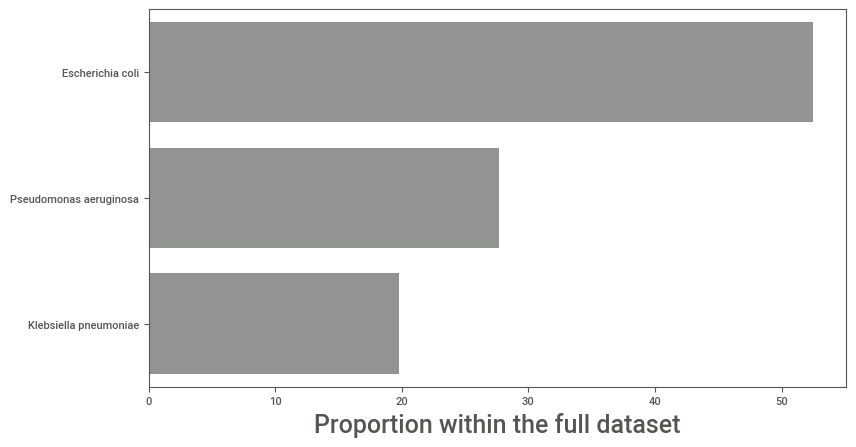

In [46]:
plt.figure(figsize=(9, 5))

sns.barplot(data=sp,
            y=sp.index,
            x=sp['species_identified'],
            palette=['xkcd:grey', 'xkcd:grey', 'xkcd:grey'])

plt.xlabel('Proportion within the full dataset')
plt.ylabel('')

plt.savefig('../../out/figures/sp_id.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/sp_id.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [47]:
# temporal sampling date

In [48]:
ecoli = mhh[mhh.species_identified == "Escherichia coli"]
kp = mhh[mhh.species_identified == "Klebsiella pneumoniae"]
pa = mhh[mhh.species_identified == "Pseudomonas aeruginosa"]

In [49]:
ecoli.reset_index(inplace=True)

In [50]:
kp.reset_index(inplace=True)

In [51]:
pa.reset_index(inplace=True)

In [52]:
pa.drop(columns=["index"], inplace=True)

/home/burgaya/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
kp.drop(columns=["index"], inplace=True)

In [54]:
ecoli.drop(columns=["index"], inplace=True)

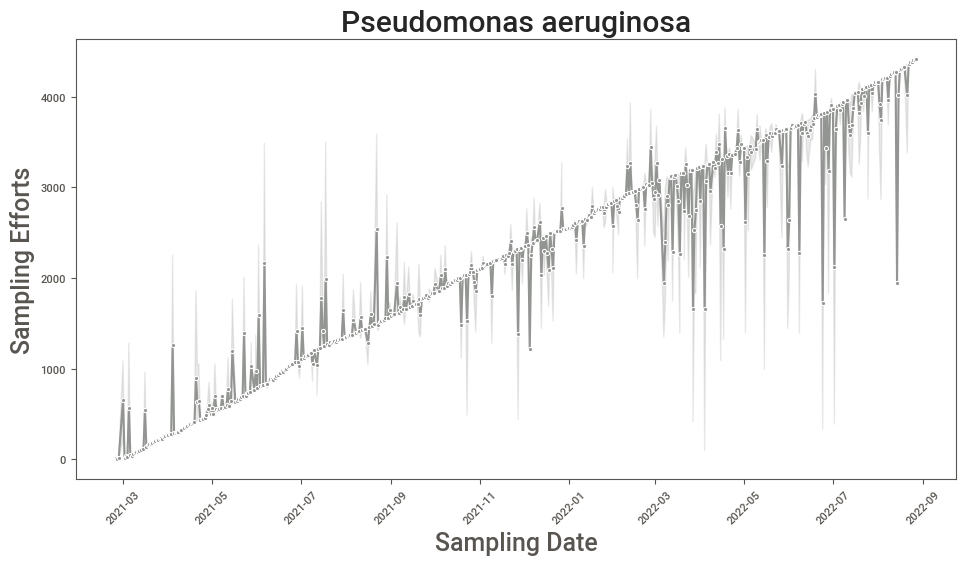

In [55]:
# Create a line plot using Seaborn ECOLI
plt.figure(figsize=(10, 6))
sns.lineplot(x='samplingdate', y=pa.index, data=pa, marker='o', color='xkcd:grey')

plt.xlabel('Sampling Date')
plt.ylabel('Sampling Efforts')
plt.title('Pseudomonas aeruginosa')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../../out/figures/sampling_efforts_pa.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/sampling_efforts_pa.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

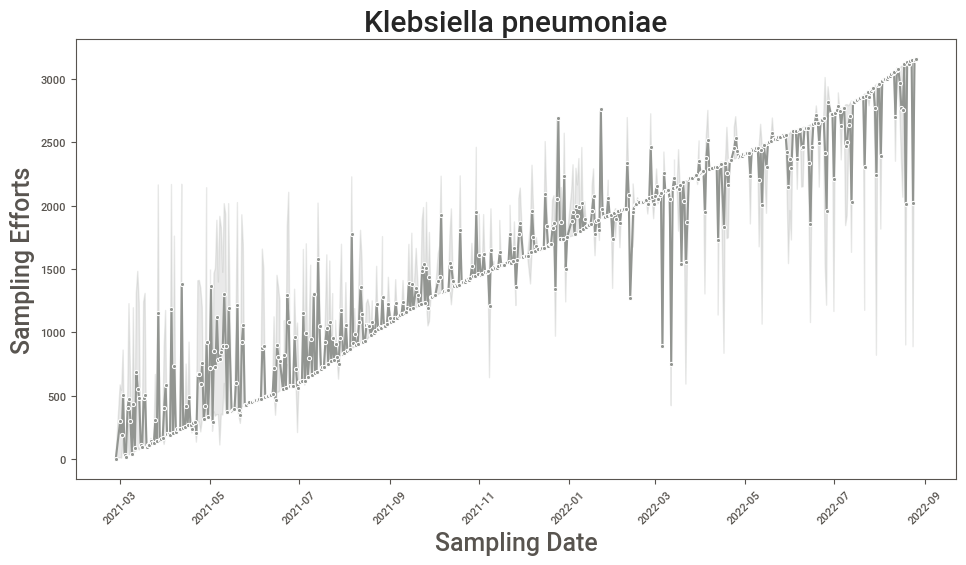

In [56]:
# Create a line plot using Seaborn ECOLI
plt.figure(figsize=(10, 6))
sns.lineplot(x='samplingdate', y=kp.index, data=kp, marker='o', color='xkcd:grey')

plt.xlabel('Sampling Date')
plt.ylabel('Sampling Efforts')
plt.title('Klebsiella pneumoniae')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../../out/figures/sampling_efforts_kp.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/sampling_efforts_kp.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

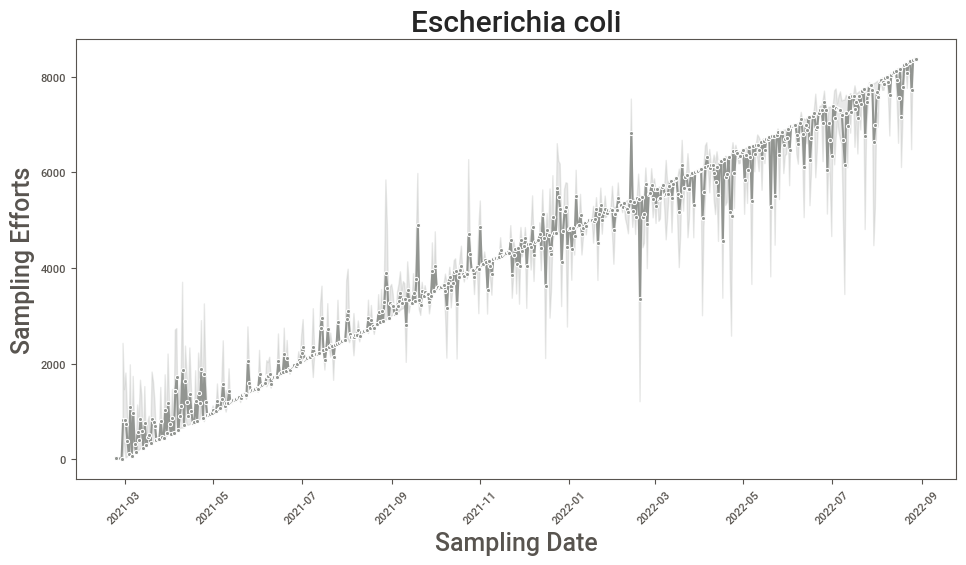

In [57]:
# Create a line plot using Seaborn ECOLI
plt.figure(figsize=(10, 6))
sns.lineplot(x='samplingdate', y=ecoli.index, data=ecoli, marker='o', color='xkcd:grey')

plt.xlabel('Sampling Date')
plt.ylabel('Sampling Efforts')
plt.title('Escherichia coli')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../../out/figures/sampling_efforts_ec.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/sampling_efforts_ec.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

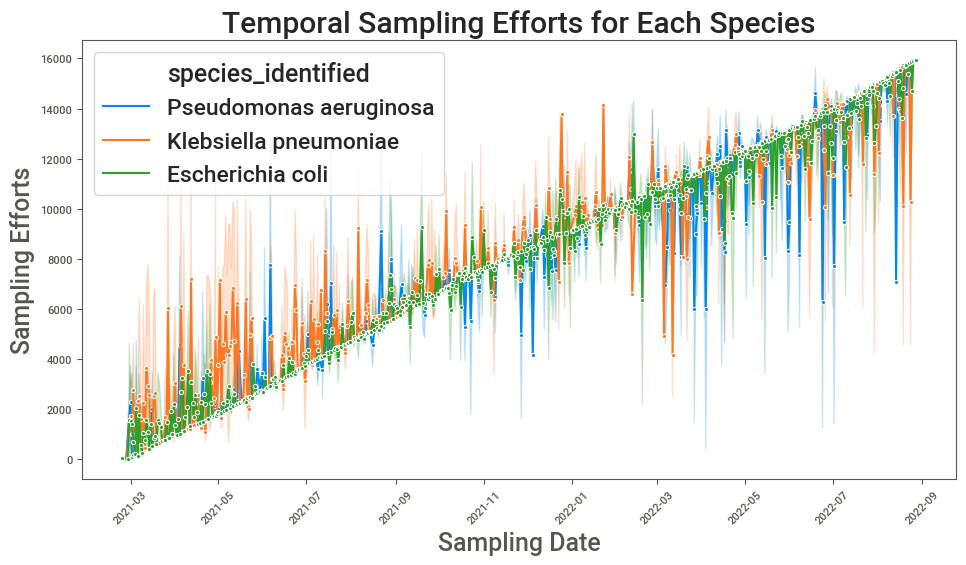

In [58]:
# Create a line plot using Seaborn

plt.figure(figsize=(10, 6))
sns.lineplot(x='samplingdate', y=mhh.index, hue='species_identified', data=mhh, marker='o')

plt.xlabel('Sampling Date')
plt.ylabel('Sampling Efforts')
plt.title('Temporal Sampling Efforts for Each Species')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [59]:
# inpatients and nosocomial
n = mhh.groupby(by=["admission_status", "acquisition"]).size()

In [60]:
nn = pd.DataFrame(n)

In [61]:
nn

0
admission_status acquisition      
inpatient        community    4631
                 nosocomial   7215
outpatient       community    4092

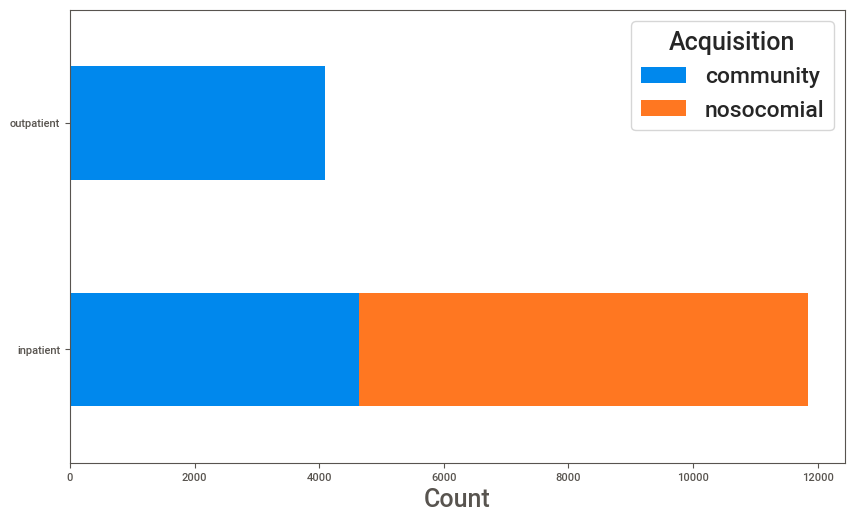

In [62]:
# Pivot the DataFrame for plotting
pivot_df = nn.pivot_table(index='admission_status', columns='acquisition', values=0, fill_value=0)

# Create the horizontal bar plot
ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 6))
ax.set_xlabel('Count')
ax.set_ylabel('')
plt.legend(title='Acquisition')
plt.show()